# Modelación de Severidad - Gastos Médicos RC

Este notebook desarrolla modelos de regresión para predecir la severidad (monto) de siniestros en la cobertura de Gastos Médicos RC.

**Dataset**: `medicos_siniestrados.csv` (183 registros)  
**Variable objetivo**: `Gastos_Medicos_RC_siniestros_monto`  
**Enfoque**: Modelos de regresión para datos de severidad positivos

In [148]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import scipy.stats as stats
from scipy.stats import gamma, lognorm
import joblib
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Librerías importadas correctamente")

Librerías importadas correctamente


In [149]:
# Carga de datos
df = pd.read_csv('../data/processed/medicos_siniestrados.csv')
print(f"Dataset cargado: {df.shape}")
print(f"Columnas: {list(df.columns)}")
df.head()

Dataset cargado: (183, 15)
Columnas: ['año_cursado', 'estudios_area', 'calif_promedio', '2_o_mas_inquilinos', 'distancia_al_campus', 'genero', 'extintor_incendios', 'Gastos_Adicionales_siniestros_num', 'Gastos_Adicionales_siniestros_monto', 'Gastos_Medicos_RC_siniestros_num', 'Gastos_Medicos_RC_siniestros_monto', 'Resp_Civil_siniestros_num', 'Resp_Civil_siniestros_monto', 'Contenidos_siniestros_num', 'Contenidos_siniestros_monto']


,año_cursado,estudios_area,calif_promedio,2_o_mas_inquilinos,distancia_al_campus,genero,extintor_incendios,Gastos_Adicionales_siniestros_num,Gastos_Adicionales_siniestros_monto,Gastos_Medicos_RC_siniestros_num,Gastos_Medicos_RC_siniestros_monto,Resp_Civil_siniestros_num,Resp_Civil_siniestros_monto,Contenidos_siniestros_num,Contenidos_siniestros_monto
0,4to año,Administracion,7.11,No,0.00,No respuesta,Si,0.00,0.00,1.00,7197.11,0.00,0.00,0.00,0.00
1,4to año,Ciencias,2.75,No,0.40,Masculino,Si,0.00,0.00,1.00,2295.65,0.00,0.00,0.00,0.00
2,4to año,Ciencias,6.19,No,0.00,Masculino,Si,0.00,0.00,1.00,2552.81,0.00,0.00,0.00,0.00
3,4to año,Otro,5.47,No,0.00,Femenino,Si,0.00,0.00,1.00,7305.59,0.00,0.00,0.00,0.00
4,3er año,Administracion,5.74,No,14.79,Femenino,Si,0.00,0.00,1.00,2697.51,0.00,0.00,0.00,0.00


In [150]:
# Análisis exploratorio de la variable objetivo
target_var = 'Gastos_Medicos_RC_siniestros_monto'
print(f"Análisis de la variable objetivo: {target_var}")
print(f"\nEstadísticas descriptivas:")
print(df[target_var].describe())

print(f"\nValores únicos: {df[target_var].nunique()}")
print(f"Valores faltantes: {df[target_var].isnull().sum()}")
print(f"Valores cero: {(df[target_var] == 0).sum()}")
print(f"Mínimo: {df[target_var].min():.2f}")
print(f"Máximo: {df[target_var].max():.2f}")

Análisis de la variable objetivo: Gastos_Medicos_RC_siniestros_monto

Estadísticas descriptivas:
count      183.00
mean     17427.24
std      18671.44
min        519.81
25%       5952.72
50%      11444.60
75%      21301.01
max     115617.30
Name: Gastos_Medicos_RC_siniestros_monto, dtype: float64

Valores únicos: 183
Valores faltantes: 0
Valores cero: 0
Mínimo: 519.81
Máximo: 115617.30


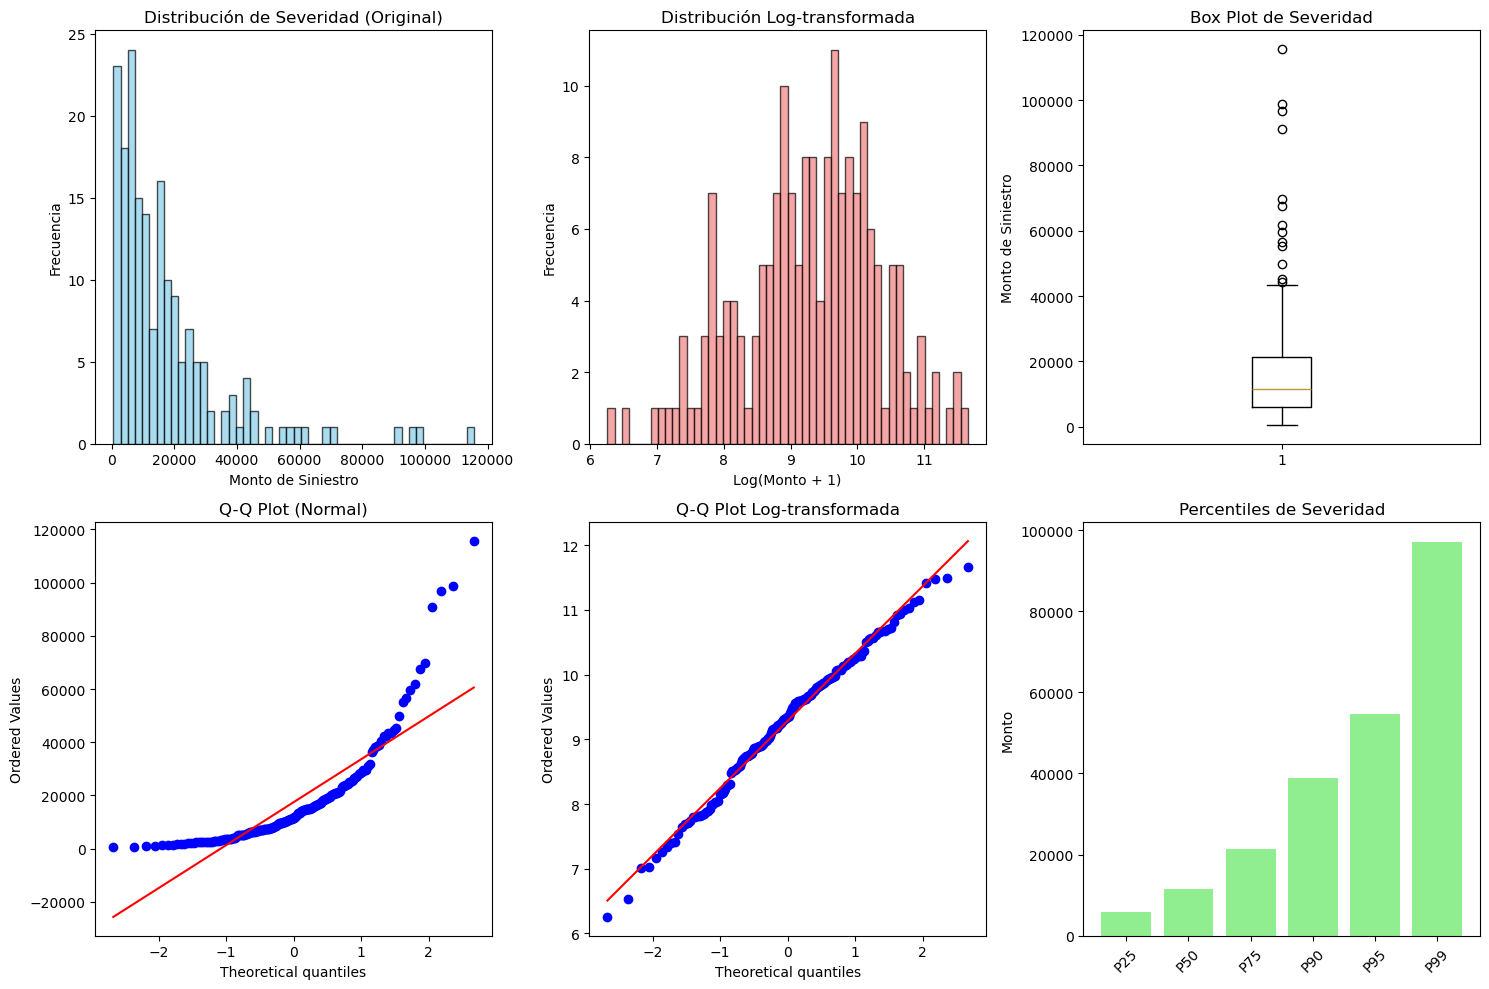


Análisis de distribución:
Asimetría (Skewness): 2.512
Curtosis: 7.848

La distribución muestra características típicas de datos de severidad:
- Asimetría positiva (cola derecha larga)
- Apropiada para modelos Gamma o Log-Normal


In [151]:
# Visualización de la distribución de severidad
plt.figure(figsize=(15, 10))

# Distribución original
plt.subplot(2, 3, 1)
plt.hist(df[target_var], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribución de Severidad (Original)')
plt.xlabel('Monto de Siniestro')
plt.ylabel('Frecuencia')

# Distribución log-transformada
plt.subplot(2, 3, 2)
log_target = np.log(df[target_var] + 1)  # +1 para evitar log(0)
plt.hist(log_target, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Distribución Log-transformada')
plt.xlabel('Log(Monto + 1)')
plt.ylabel('Frecuencia')

# Box plot
plt.subplot(2, 3, 3)
plt.boxplot(df[target_var])
plt.title('Box Plot de Severidad')
plt.ylabel('Monto de Siniestro')

# Q-Q plot normal
plt.subplot(2, 3, 4)
stats.probplot(df[target_var], dist="norm", plot=plt)
plt.title('Q-Q Plot (Normal)')

# Q-Q plot lognormal
plt.subplot(2, 3, 5)
stats.probplot(log_target, dist="norm", plot=plt)
plt.title('Q-Q Plot Log-transformada')

# Estadísticas por percentiles
plt.subplot(2, 3, 6)
percentiles = [25, 50, 75, 90, 95, 99]
values = [np.percentile(df[target_var], p) for p in percentiles]
plt.bar(range(len(percentiles)), values, color='lightgreen')
plt.xticks(range(len(percentiles)), [f'P{p}' for p in percentiles])
plt.title('Percentiles de Severidad')
plt.ylabel('Monto')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"\nAnálisis de distribución:")
print(f"Asimetría (Skewness): {stats.skew(df[target_var]):.3f}")
print(f"Curtosis: {stats.kurtosis(df[target_var]):.3f}")
print(f"\nLa distribución muestra características típicas de datos de severidad:")
print(f"- Asimetría positiva (cola derecha larga)")
print(f"- Apropiada para modelos Gamma o Log-Normal")

In [152]:
# Preparación de variables predictoras
# Selección de variables independientes (excluyendo variables objetivo y otras coberturas)
exclude_cols = ['Gastos_Medicos_RC_siniestros_num', 'Gastos_Medicos_RC_siniestros_monto',
                'Resp_Civil_siniestros_num', 'Resp_Civil_siniestros_monto',
                'Contenidos_siniestros_num', 'Contenidos_siniestros_monto',
                'Gastos_Adicionales_siniestros_num', 'Gastos_Adicionales_siniestros_monto']

feature_cols = [col for col in df.columns if col not in exclude_cols]
print(f"Variables predictoras seleccionadas: {feature_cols}")

X = df[feature_cols].copy()
y = df[target_var].copy()

print(f"\nShape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"\nTipos de datos en X:")
print(X.dtypes)

# Verificar valores faltantes
print(f"\nValores faltantes en X:")
print(X.isnull().sum())

Variables predictoras seleccionadas: ['año_cursado', 'estudios_area', 'calif_promedio', '2_o_mas_inquilinos', 'distancia_al_campus', 'genero', 'extintor_incendios']

Shape de X: (183, 7)
Shape de y: (183,)

Tipos de datos en X:
año_cursado             object
estudios_area           object
calif_promedio         float64
2_o_mas_inquilinos      object
distancia_al_campus    float64
genero                  object
extintor_incendios      object
dtype: object

Valores faltantes en X:
año_cursado            0
estudios_area          0
calif_promedio         0
2_o_mas_inquilinos     0
distancia_al_campus    0
genero                 0
extintor_incendios     0
dtype: int64


In [153]:
# Codificación de variables categóricas
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

print(f"Variables categóricas: {categorical_cols}")
print(f"Variables numéricas: {numerical_cols}")

# One-hot encoding para variables categóricas
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=False)
print(f"\nShape después de encoding: {X_encoded.shape}")
print(f"Nuevas columnas creadas: {X_encoded.shape[1] - X.shape[1]}")

# Mostrar las primeras columnas para verificar
print(f"\nPrimeras 10 columnas: {list(X_encoded.columns[:10])}")

Variables categóricas: ['año_cursado', 'estudios_area', '2_o_mas_inquilinos', 'genero', 'extintor_incendios']
Variables numéricas: ['calif_promedio', 'distancia_al_campus']

Shape después de encoding: (183, 19)
Nuevas columnas creadas: 12

Primeras 10 columnas: ['calif_promedio', 'distancia_al_campus', 'año_cursado_1er año', 'año_cursado_2do año', 'año_cursado_3er año', 'año_cursado_4to año', 'año_cursado_posgrado', 'estudios_area_Administracion', 'estudios_area_Ciencias', 'estudios_area_Humanidades']


In [154]:
# Estandarización de variables numéricas
scaler = StandardScaler()
X_scaled = X_encoded.copy()

if numerical_cols:
    # Identificar las columnas numéricas en el dataset codificado
    numerical_cols_encoded = [col for col in X_encoded.columns 
                             if any(num_col == col for num_col in numerical_cols)]
    
    print(f"Variables numéricas a estandarizar: {numerical_cols_encoded}")
    X_scaled[numerical_cols_encoded] = scaler.fit_transform(X_encoded[numerical_cols_encoded])
    print(f"Variables numéricas estandarizadas exitosamente")
else:
    print("No hay variables numéricas para estandarizar")

print(f"\nDataset final preparado: {X_scaled.shape}")
print(f"Estadísticas de las variables estandarizadas:")
if numerical_cols_encoded:
    print(X_scaled[numerical_cols_encoded].describe())

Variables numéricas a estandarizar: ['calif_promedio', 'distancia_al_campus']
Variables numéricas estandarizadas exitosamente

Dataset final preparado: (183, 19)
Estadísticas de las variables estandarizadas:
       calif_promedio  distancia_al_campus
count          183.00               183.00
mean             0.00                -0.00
std              1.00                 1.00
min             -2.41                -0.60
25%             -0.82                -0.60
50%              0.19                -0.60
75%              0.78                 0.17
max              1.85                 4.99


In [155]:
# División del dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

print(f"\nEstadísticas de la variable objetivo:")
print(f"Entrenamiento - Media: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"Prueba - Media: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

print(f"\nRango de valores:")
print(f"Entrenamiento: [{y_train.min():.2f}, {y_train.max():.2f}]")
print(f"Prueba: [{y_test.min():.2f}, {y_test.max():.2f}]")

Tamaño del conjunto de entrenamiento: (146, 19)
Tamaño del conjunto de prueba: (37, 19)

Estadísticas de la variable objetivo:
Entrenamiento - Media: 16443.62, Std: 16488.51
Prueba - Media: 21308.55, Std: 25456.58

Rango de valores:
Entrenamiento: [519.81, 96690.40]
Prueba: [1533.90, 115617.30]


In [156]:
# Selección de variables con GLM LogNormal y Gamma por separado
from sklearn.feature_selection import RFE
from sklearn.linear_model import TweedieRegressor, GammaRegressor
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

print("Selección de variables con GLM LogNormal y Gamma separados")

# 1. Selección con LogNormal (Tweedie power=0, link=log)
print("\n1. Selección con GLM LogNormal...")
lognormal_model = TweedieRegressor(power=0, alpha=0.1, link='log', max_iter=1000)

# RFE stepwise con LogNormal
n_features_target = min(12, X_train.shape[1] // 2)
rfe_lognormal = RFE(estimator=lognormal_model, n_features_to_select=n_features_target, step=1)
rfe_lognormal.fit(X_train, y_train)

features_lognormal = X_train.columns[rfe_lognormal.support_].tolist()
print(f"Variables LogNormal ({len(features_lognormal)}): {features_lognormal}")

# Evaluar MAE con LogNormal
cv = KFold(n_splits=5, shuffle=True, random_state=42)
X_train_lognormal = X_train[features_lognormal]
scores_lognormal = cross_val_score(lognormal_model, X_train_lognormal, y_train, 
                                  cv=cv, scoring='neg_mean_absolute_error')
mae_lognormal = -scores_lognormal.mean()
print(f"MAE LogNormal: {mae_lognormal:.2f}")

# 2. Selección con Gamma (link=log)
print("\n2. Selección con GLM Gamma...")
gamma_model = GammaRegressor(alpha=0.1, max_iter=1000)

# RFE stepwise con Gamma
rfe_gamma = RFE(estimator=gamma_model, n_features_to_select=n_features_target, step=1)
rfe_gamma.fit(X_train, y_train)

features_gamma = X_train.columns[rfe_gamma.support_].tolist()
print(f"Variables Gamma ({len(features_gamma)}): {features_gamma}")

# Evaluar MAE con Gamma
X_train_gamma = X_train[features_gamma]
scores_gamma = cross_val_score(gamma_model, X_train_gamma, y_train, 
                              cv=cv, scoring='neg_mean_absolute_error')
mae_gamma = -scores_gamma.mean()
print(f"MAE Gamma: {mae_gamma:.2f}")

# 3. Combinar características de ambos métodos
print("\n3. Evaluando conjunto combinado...")
features_combined = list(set(features_lognormal + features_gamma))
print(f"Variables combinadas ({len(features_combined)}): {features_combined}")

# Evaluar conjunto combinado con modelo simple
from sklearn.linear_model import LinearRegression
simple_model = LinearRegression()
X_train_combined = X_train[features_combined]
scores_combined = cross_val_score(simple_model, X_train_combined, y_train, 
                                 cv=cv, scoring='neg_mean_absolute_error')
mae_combined = -scores_combined.mean()
print(f"MAE combinado: {mae_combined:.2f}")

# Seleccionar el mejor conjunto de características
selection_results = {
    'lognormal': {'features': features_lognormal, 'mae': mae_lognormal},
    'gamma': {'features': features_gamma, 'mae': mae_gamma},
    'combined': {'features': features_combined, 'mae': mae_combined}
}

best_selection = min(selection_results.items(), key=lambda x: x[1]['mae'])
selected_features = best_selection[1]['features']

print(f"\n=== MEJOR SELECCIÓN ===")
print(f"Método: {best_selection[0]}")
print(f"MAE: {best_selection[1]['mae']:.2f}")
print(f"Características finales ({len(selected_features)}):")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")

# Crear datasets finales
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"\nShape final: Train {X_train_selected.shape}, Test {X_test_selected.shape}")

Selección de variables con GLM LogNormal y Gamma separados

1. Selección con GLM LogNormal...
Variables LogNormal (9): ['distancia_al_campus', 'año_cursado_1er año', 'estudios_area_Ciencias', '2_o_mas_inquilinos_No', '2_o_mas_inquilinos_Si', 'genero_No respuesta', 'genero_Otro', 'extintor_incendios_No', 'extintor_incendios_Si']
MAE LogNormal: 10388.79

2. Selección con GLM Gamma...
Variables Gamma (9): ['distancia_al_campus', 'año_cursado_1er año', 'año_cursado_posgrado', 'estudios_area_Administracion', '2_o_mas_inquilinos_No', '2_o_mas_inquilinos_Si', 'genero_Otro', 'extintor_incendios_No', 'extintor_incendios_Si']
MAE Gamma: 10060.81

3. Evaluando conjunto combinado...
Variables combinadas (11): ['extintor_incendios_Si', '2_o_mas_inquilinos_No', '2_o_mas_inquilinos_Si', 'genero_No respuesta', 'extintor_incendios_No', 'año_cursado_1er año', 'distancia_al_campus', 'genero_Otro', 'estudios_area_Administracion', 'año_cursado_posgrado', 'estudios_area_Ciencias']
MAE combinado: 10623.91

=

In [157]:
# LazyPredict - Exploración de modelos
try:
    from lazypredict.Supervised import LazyRegressor
    
    print("Ejecutando LazyPredict...")
    
    # Configurar LazyRegressor
    lazy_reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
    
    # Usar muestra pequeña
    sample_size = min(100, len(X_train_selected))
    X_sample = X_train_selected.sample(n=sample_size, random_state=42)
    y_sample = y_train.loc[X_sample.index]
    
    # Ejecutar LazyPredict
    models, predictions = lazy_reg.fit(X_sample, X_test_selected, y_sample, y_test)
    
    print("Top 10 modelos:")
    print(models.head(10))
    
    # Top 5 modelos
    top_5_models = models.head(5).index.tolist()
    print(f"Top 5 modelos: {top_5_models}")
    
except ImportError:
    print("LazyPredict no disponible. Usando modelos predefinidos")
    top_5_models = ['RandomForestRegressor', 'GradientBoostingRegressor', 
                   'LinearRegression', 'Ridge', 'ElasticNet']
except Exception as e:
    print(f"Error en LazyPredict: {e}")
    top_5_models = ['RandomForestRegressor', 'GradientBoostingRegressor', 
                   'LinearRegression', 'Ridge', 'ElasticNet']

Ejecutando LazyPredict...


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 1
[LightGBM] [Info] Start training from score 18587.710768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [158]:
# Configuración de modelos incluyendo LogNormal y Gamma
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, HuberRegressor, TweedieRegressor, GammaRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

print("Configuración de modelos incluyendo GLM LogNormal y Gamma")

# Modelos con hiperparámetros incluyendo distribuciones de severidad
models_params = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge': {
        'model': Ridge(random_state=42),
        'params': {
            'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
        }
    },
    'Lasso': {
        'model': Lasso(random_state=42, max_iter=2000),
        'params': {
            'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(random_state=42, max_iter=2000),
        'params': {
            'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
            'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
        }
    },
    'HuberRegressor': {
        'model': HuberRegressor(max_iter=200),
        'params': {
            'epsilon': [1.1, 1.35, 1.5, 2.0, 3.0],
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]
        }
    },
    'TweedieRegressor_LogNormal': {
        'model': TweedieRegressor(power=0, link='log', max_iter=1000),
        'params': {
            'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
            'solver': ['lbfgs', 'newton-cholesky']
        }
    },
    'GammaRegressor': {
        'model': GammaRegressor(max_iter=1000),
        'params': {
            'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
            'solver': ['lbfgs', 'newton-cholesky']
        }
    },
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 10, 15, None],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 5, 10],
            'max_features': ['sqrt', 'log2', 0.5, 0.8]
        }
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
            'max_depth': [3, 4, 5, 6],
            'subsample': [0.8, 0.9, 1.0],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 3, 5]
        }
    },
    'ExtraTreesRegressor': {
        'model': ExtraTreesRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 10, 15, None],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 5, 10],
            'max_features': ['sqrt', 'log2', 0.5, 0.8]
        }
    },
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 7, 10, 15, 20],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree'],
            'p': [1, 2]  # Manhattan (1) vs Euclidean (2)
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10, 100, 1000],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1.0],
            'kernel': ['rbf', 'linear', 'poly'],
            'epsilon': [0.01, 0.1, 0.2, 0.5, 1.0]
        }
    }
}

print(f"Modelos configurados: {list(models_params.keys())}")
print("IMPORTANTE: Incluye TweedieRegressor_LogNormal y GammaRegressor para severidad")

Configuración de modelos incluyendo GLM LogNormal y Gamma
Modelos configurados: ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'HuberRegressor', 'TweedieRegressor_LogNormal', 'GammaRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor', 'ExtraTreesRegressor', 'KNeighborsRegressor', 'SVR']
IMPORTANTE: Incluye TweedieRegressor_LogNormal y GammaRegressor para severidad


In [159]:
# Grid Search con los mejores de LazyPredict + LogNormal + Gamma
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
import time

print("Grid Search con mejores de LazyPredict + LogNormal + Gamma")

# Configuración CV
cv_folds = min(5, len(X_train_selected) // 8)
cv = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

best_models = {}

# Modelos que SIEMPRE se deben incluir (LogNormal y Gamma)
mandatory_models = ['TweedieRegressor_LogNormal', 'GammaRegressor']

# Obtener los mejores de LazyPredict si están disponibles
if 'top_5_models' in locals():
    lazypredict_models = [model for model in top_5_models if model in models_params]
    print(f"Mejores de LazyPredict: {lazypredict_models}")
else:
    lazypredict_models = ['RandomForestRegressor', 'GradientBoostingRegressor', 
                         'Ridge', 'LinearRegression', 'HuberRegressor']
    print(f"Modelos predefinidos (LazyPredict no disponible): {lazypredict_models}")

# Combinar modelos: LazyPredict + obligatorios
models_to_optimize = list(set(lazypredict_models + mandatory_models))

# Agregar algunos modelos adicionales buenos para MAE si hay espacio
additional_good_models = ['ExtraTreesRegressor', 'ElasticNet']
for model in additional_good_models:
    if model not in models_to_optimize and model in models_params:
        models_to_optimize.append(model)

print(f"\\nModelos a optimizar ({len(models_to_optimize)}): {models_to_optimize}")

# Optimizar cada modelo
for model_name in models_to_optimize:
    if model_name not in models_params:
        print(f"Saltando {model_name}: no configurado")
        continue
        
    print(f"\\nOptimizando {model_name}...")
    start_time = time.time()
    
    model_config = models_params[model_name]
    
    if model_config['params']:  # Con hiperparámetros
        # Para GLM usar GridSearchCV (menos combinaciones), para otros RandomizedSearchCV
        if model_name in ['TweedieRegressor_LogNormal', 'GammaRegressor']:
            search = GridSearchCV(
                estimator=model_config['model'],
                param_grid=model_config['params'],
                cv=cv,
                scoring='neg_mean_absolute_error',
                n_jobs=-1,
                verbose=0
            )
        else:
            # RandomizedSearchCV para modelos con muchas combinaciones
            n_iter = min(50, len(list(model_config['params'].values())[0]) * 8)
            search = RandomizedSearchCV(
                estimator=model_config['model'],
                param_distributions=model_config['params'],
                n_iter=n_iter,
                cv=cv,
                scoring='neg_mean_absolute_error',
                n_jobs=-1,
                verbose=0,
                random_state=42
            )
        
        search.fit(X_train_selected, y_train)
        best_model = search.best_estimator_
        best_params = search.best_params_
        best_score = -search.best_score_
        
        print(f"Mejores parámetros: {best_params}")
        print(f"MAE CV: {best_score:.2f}")
        
    else:  # Sin hiperparámetros
        best_model = model_config['model']
        best_model.fit(X_train_selected, y_train)
        
        cv_scores = cross_val_score(best_model, X_train_selected, y_train, 
                                   cv=cv, scoring='neg_mean_absolute_error')
        best_score = -cv_scores.mean()
        best_params = "N/A"
        
        print(f"MAE CV: {best_score:.2f}")
    
    # Guardar modelo
    best_models[model_name] = {
        'model': best_model,
        'params': best_params,
        'cv_mae': best_score
    }
    
    elapsed_time = time.time() - start_time
    print(f"Tiempo: {elapsed_time:.1f}s")

print(f"\\n=== RESULTADOS DE OPTIMIZACIÓN ===")
print("Modelos ordenados por MAE CV (menor es mejor):")
sorted_models = sorted(best_models.items(), key=lambda x: x[1]['cv_mae'])
for i, (model_name, info) in enumerate(sorted_models, 1):
    print(f"{i}. {model_name}: MAE={info['cv_mae']:.2f}")

# Verificar que LogNormal y Gamma están incluidos
lognormal_included = any('LogNormal' in model or 'Tweedie' in model for model in best_models.keys())
gamma_included = any('Gamma' in model for model in best_models.keys())
print(f"\\nLogNormal incluido: {lognormal_included}")
print(f"Gamma incluido: {gamma_included}")

print(f"\\nOptimización completada: {len(best_models)} modelos")

Grid Search con mejores de LazyPredict + LogNormal + Gamma
Mejores de LazyPredict: ['GammaRegressor']
\nModelos a optimizar (4): ['TweedieRegressor_LogNormal', 'GammaRegressor', 'ExtraTreesRegressor', 'ElasticNet']
\nOptimizando TweedieRegressor_LogNormal...
Mejores parámetros: {'alpha': 100.0, 'solver': 'lbfgs'}
MAE CV: 10691.82
Tiempo: 6.8s
\nOptimizando GammaRegressor...
Mejores parámetros: {'alpha': 0.1, 'solver': 'lbfgs'}
MAE CV: 10060.81
Tiempo: 0.3s
\nOptimizando ExtraTreesRegressor...
Mejores parámetros: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}
MAE CV: 10203.86
Tiempo: 14.2s
\nOptimizando ElasticNet...
Mejores parámetros: {'l1_ratio': 0.9, 'alpha': 1.0}
MAE CV: 10147.57
Tiempo: 0.8s
\n=== RESULTADOS DE OPTIMIZACIÓN ===
Modelos ordenados por MAE CV (menor es mejor):
1. GammaRegressor: MAE=10060.81
2. ElasticNet: MAE=10147.57
3. ExtraTreesRegressor: MAE=10203.86
4. TweedieRegressor_LogNormal: MAE=10691.82
\nL

In [160]:
# Evaluación de modelos
print("Evaluación en conjunto de prueba")

# Reimportar función
from sklearn.metrics import r2_score as r2_score_func

def calculate_gini_coefficient(y_true, y_pred):
    sorted_indices = np.argsort(y_pred)
    sorted_y_true = y_true.iloc[sorted_indices] if hasattr(y_true, 'iloc') else y_true[sorted_indices]
    n = len(sorted_y_true)
    gini = (2 * np.sum((np.arange(1, n + 1) * sorted_y_true)) / (n * np.sum(sorted_y_true))) - (n + 1) / n
    return gini

evaluation_results = []

for model_name, model_info in best_models.items():
    model = model_info['model']
    
    # Predicciones
    y_pred = model.predict(X_test_selected)
    
    # Verificar valores válidos
    if np.any(np.isinf(y_pred)) or np.any(np.isnan(y_pred)):
        print(f"Saltando {model_name}: valores inválidos")
        continue
    
    # Valores positivos
    y_pred = np.maximum(y_pred, 0.01)
    
    # Métricas
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2_value = r2_score_func(y_test, y_pred)
    
    try:
        gini = calculate_gini_coefficient(y_test, y_pred)
    except:
        gini = 0.0
    
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    result = {
        'Modelo': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2_value,
        'Gini': gini,
        'MAPE': mape,
        'CV_MAE': model_info['cv_mae']
    }
    
    evaluation_results.append(result)
    
    print(f"{model_name}: MAE={mae:.2f}, R²={r2_value:.4f}, Gini={gini:.4f}")

# Resultados
results_df = pd.DataFrame(evaluation_results)
results_df = results_df.sort_values('MAE')

print("\nResumen de resultados:")
print(results_df.round(4))

# Mejor modelo
if len(results_df) > 0:
    best_model_name = results_df.iloc[0]['Modelo']
    print(f"\nMejor modelo: {best_model_name}")
    print(f"MAE: {results_df.iloc[0]['MAE']:.2f}")
    print(f"R²: {results_df.iloc[0]['R²']:.4f}")
    print(f"Gini: {results_df.iloc[0]['Gini']:.4f}")
else:
    print("No se evaluaron modelos válidos")

Evaluación en conjunto de prueba
TweedieRegressor_LogNormal: MAE=14807.37, R²=0.2277, Gini=0.2586
GammaRegressor: MAE=14410.84, R²=0.1385, Gini=0.2868
ExtraTreesRegressor: MAE=14372.22, R²=0.2676, Gini=0.3477
ElasticNet: MAE=14432.19, R²=0.1405, Gini=0.2924

Resumen de resultados:
                       Modelo      MAE     RMSE   R²  Gini   MAPE   CV_MAE
2         ExtraTreesRegressor 14372.22 21489.38 0.27  0.35 142.68 10203.86
1              GammaRegressor 14410.84 23306.70 0.14  0.29 130.89 10060.81
3                  ElasticNet 14432.19 23279.29 0.14  0.29 138.72 10147.57
0  TweedieRegressor_LogNormal 14807.37 22066.65 0.23  0.26 126.74 10691.82

Mejor modelo: ExtraTreesRegressor
MAE: 14372.22
R²: 0.2676
Gini: 0.3477


=== ANÁLISIS DE RESIDUOS - ExtraTreesRegressor ===


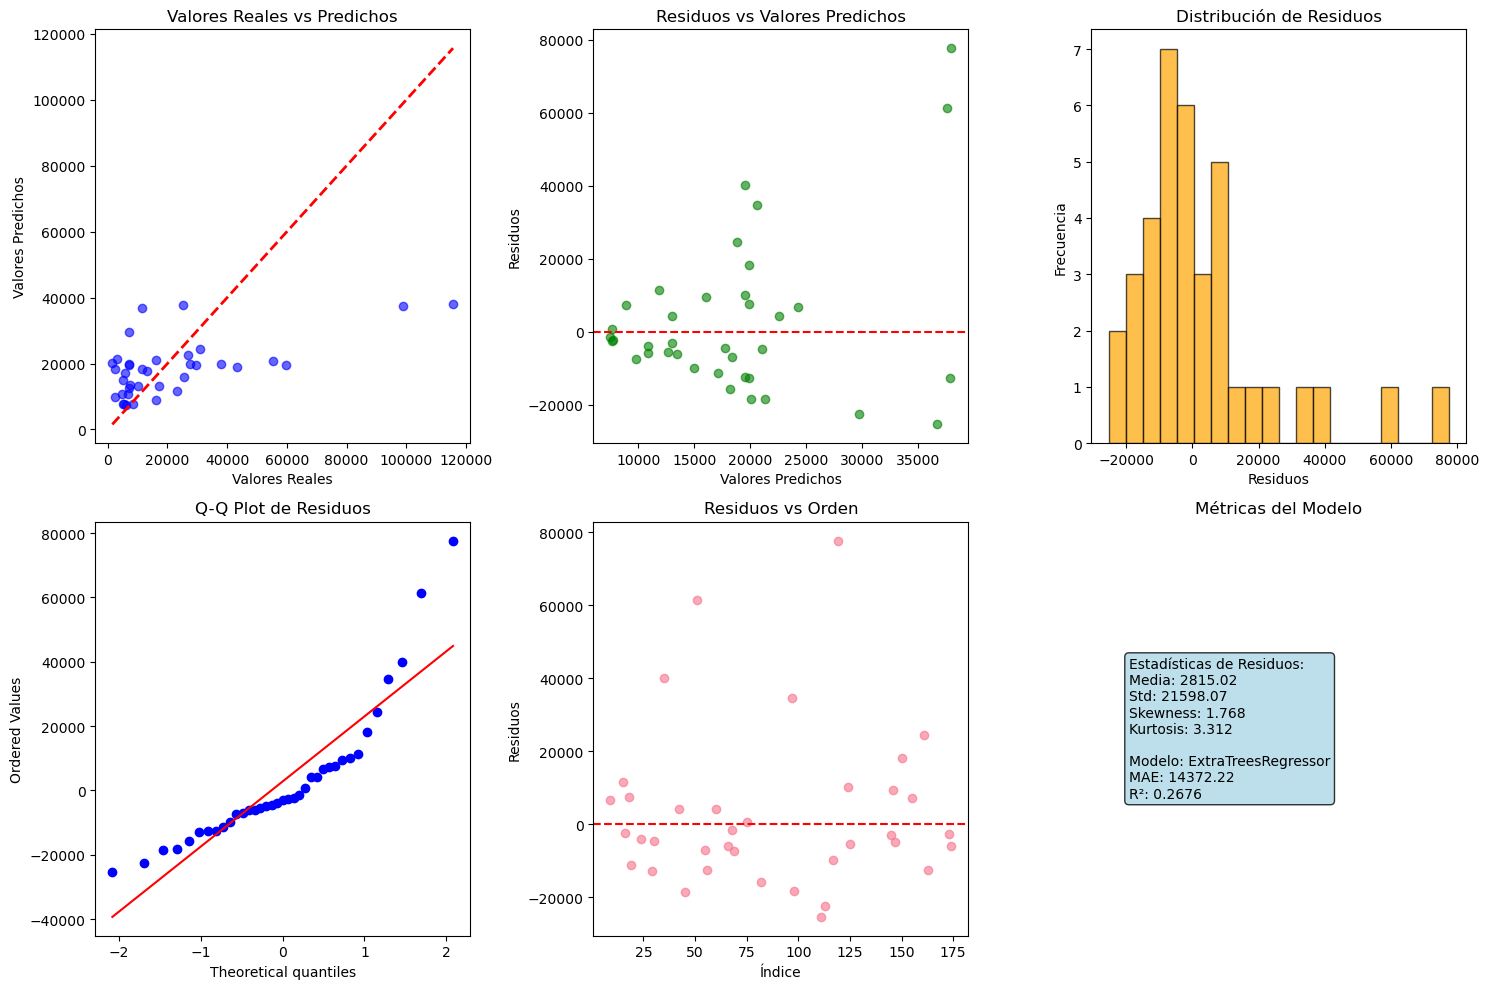

In [161]:
# Análisis de residuos del mejor modelo
best_model_name = results_df.iloc[0]['Modelo']
best_model = best_models[best_model_name]['model']
y_pred_best = best_model.predict(X_test_selected)

# Calcular residuos
residuals = y_test - y_pred_best

print(f"=== ANÁLISIS DE RESIDUOS - {best_model_name} ===")

plt.figure(figsize=(15, 10))

# Gráfico de dispersión: Valores reales vs predichos
plt.subplot(2, 3, 1)
plt.scatter(y_test, y_pred_best, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Valores Reales vs Predichos')

# Gráfico de residuos vs valores predichos
plt.subplot(2, 3, 2)
plt.scatter(y_pred_best, residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Residuos vs Valores Predichos')

# Histograma de residuos
plt.subplot(2, 3, 3)
plt.hist(residuals, bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Distribución de Residuos')

# Q-Q plot de residuos
plt.subplot(2, 3, 4)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot de Residuos')

# Residuos vs orden
plt.subplot(2, 3, 5)
plt.plot(residuals, marker='o', linestyle='', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Índice')
plt.ylabel('Residuos')
plt.title('Residuos vs Orden')

# Métricas de residuos
plt.subplot(2, 3, 6)
# Calcular valores para evitar problemas con f-strings
residuals_mean = residuals.mean()
residuals_std = residuals.std()
residuals_skew = stats.skew(residuals)
residuals_kurt = stats.kurtosis(residuals)
mae_val = mean_absolute_error(y_test, y_pred_best)
r2_val = r2_score_func(y_test, y_pred_best)

metrics_text = f"""Estadísticas de Residuos:
Media: {residuals_mean:.2f}
Std: {residuals_std:.2f}
Skewness: {residuals_skew:.3f}
Kurtosis: {residuals_kurt:.3f}

Modelo: {best_model_name}
MAE: {mae_val:.2f}
R²: {r2_val:.4f}"""

plt.text(0.1, 0.5, metrics_text, transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='center', 
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
plt.axis('off')
plt.title('Métricas del Modelo')

plt.tight_layout()
plt.show()

=== IMPORTANCIA DE CARACTERÍSTICAS - ExtraTreesRegressor ===
Top 10 características más importantes:
                        feature  importance
0           distancia_al_campus        0.22
4         2_o_mas_inquilinos_No        0.20
5         2_o_mas_inquilinos_Si        0.19
7         extintor_incendios_No        0.10
8         extintor_incendios_Si        0.10
2          año_cursado_posgrado        0.08
1           año_cursado_1er año        0.04
3  estudios_area_Administracion        0.03
6                   genero_Otro        0.03


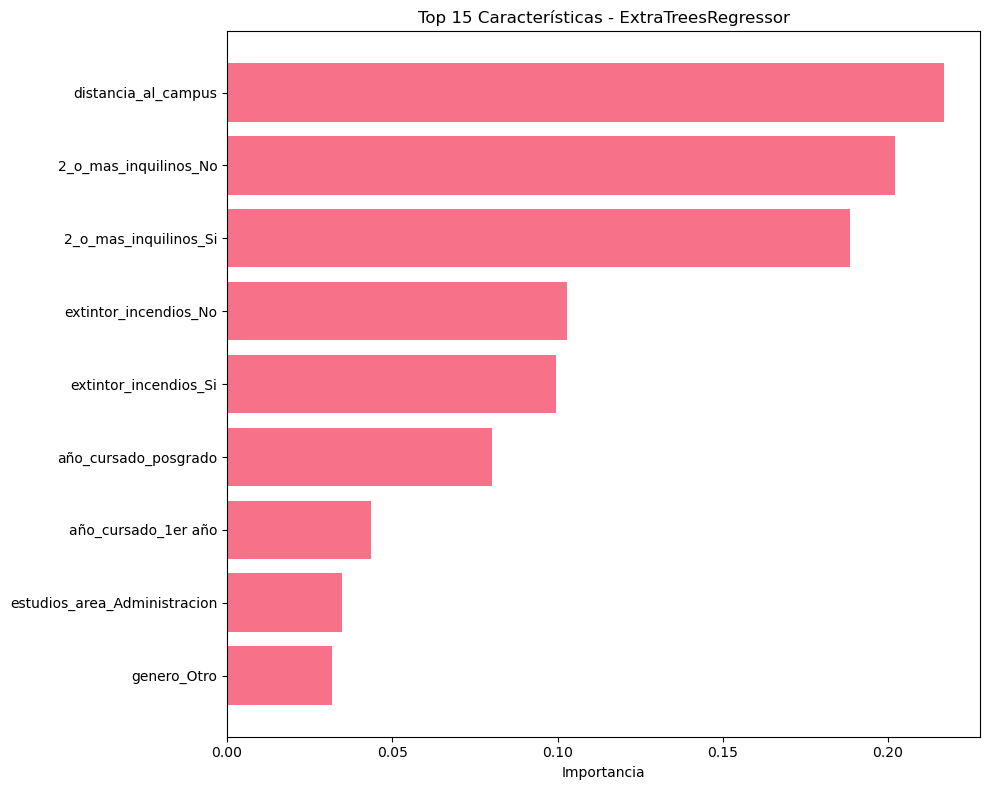

In [162]:
# Importancia de características (si el modelo lo soporta)
if hasattr(best_model, 'feature_importances_'):
    print(f"=== IMPORTANCIA DE CARACTERÍSTICAS - {best_model_name} ===")
    
    # Obtener importancias
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 10 características más importantes:")
    print(feature_importance.head(10))
    
    # Visualización
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importancia')
    plt.title(f'Top 15 Características - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
elif hasattr(best_model, 'coef_'):
    print(f"=== COEFICIENTES DEL MODELO - {best_model_name} ===")
    
    # Obtener coeficientes
    feature_coef = pd.DataFrame({
        'feature': selected_features,
        'coefficient': best_model.coef_
    })
    feature_coef['abs_coef'] = np.abs(feature_coef['coefficient'])
    feature_coef = feature_coef.sort_values('abs_coef', ascending=False)
    
    print("Top 10 características con mayor impacto:")
    print(feature_coef.head(10)[['feature', 'coefficient']])
    
    # Visualización
    plt.figure(figsize=(10, 8))
    top_features = feature_coef.head(15)
    colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
    plt.barh(range(len(top_features)), top_features['coefficient'], color=colors)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Coeficiente')
    plt.title(f'Top 15 Coeficientes - {best_model_name}')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
else:
    print(f"El modelo {best_model_name} no soporta análisis de importancia de características")

In [163]:
# Guardar el mejor modelo
import os

# Crear directorio models si no existe
os.makedirs('../models', exist_ok=True)

# Guardar el mejor modelo
model_filename = f'../models/severidad_medicos_{best_model_name.lower()}_model.pkl'

# Preparar objeto para guardar (modelo + información adicional)
model_package = {
    'model': best_model,
    'scaler': scaler,
    'selected_features': selected_features,
    'model_name': best_model_name,
    'performance_metrics': {
        'MAE': results_df.iloc[0]['MAE'],
        'R²': results_df.iloc[0]['R²'],
        'Gini': results_df.iloc[0]['Gini'],
        'RMSE': results_df.iloc[0]['RMSE']
    },
    'target_variable': target_var,
    'training_info': {
        'n_samples_train': len(X_train),
        'n_samples_test': len(X_test),
        'n_features_selected': len(selected_features)
    }
}

# Guardar modelo
joblib.dump(model_package, model_filename)

print(f"=== MODELO GUARDADO ===")
print(f"Archivo: {model_filename}")
print(f"Modelo: {best_model_name}")
print(f"Variable objetivo: {target_var}")
print(f"Características seleccionadas: {len(selected_features)}")
print(f"MAE: {results_df.iloc[0]['MAE']:.2f}")
print(f"R²: {results_df.iloc[0]['R²']:.4f}")

# Verificar que el archivo se guardó correctamente
if os.path.exists(model_filename):
    file_size = os.path.getsize(model_filename)
    print(f"Tamaño del archivo: {file_size} bytes")
    print("✓ Modelo guardado exitosamente")
else:
    print("✗ Error al guardar el modelo")

=== MODELO GUARDADO ===
Archivo: ../models/severidad_medicos_extratreesregressor_model.pkl
Modelo: ExtraTreesRegressor
Variable objetivo: Gastos_Medicos_RC_siniestros_monto
Características seleccionadas: 9
MAE: 14372.22
R²: 0.2676
Tamaño del archivo: 973361 bytes
✓ Modelo guardado exitosamente


In [164]:
# Prueba de carga del modelo guardado
try:
    # Cargar modelo
    loaded_package = joblib.load(model_filename)
    loaded_model = loaded_package['model']
    loaded_scaler = loaded_package['scaler']
    loaded_features = loaded_package['selected_features']
    
    # Verificar que funciona correctamente
    test_predictions = loaded_model.predict(X_test_selected[:5])
    
    print(f"=== VERIFICACIÓN DEL MODELO CARGADO ===")
    print(f"Modelo cargado: {loaded_package['model_name']}")
    print(f"Características: {len(loaded_features)}")
    print(f"Variable objetivo: {loaded_package['target_variable']}")
    print(f"Métricas guardadas:")
    for metric, value in loaded_package['performance_metrics'].items():
        print(f"  {metric}: {value:.4f}")
    
    print(f"\nPredicciones de prueba (5 primeras):")
    for i, pred in enumerate(test_predictions):
        real_val = y_test.iloc[i]
        print(f"  Muestra {i+1}: Real={real_val:.2f}, Predicho={pred:.2f}")
    
    print(f"\n✓ Modelo funciona correctamente después de la carga")
    
except Exception as e:
    print(f"✗ Error al cargar el modelo: {e}")

=== VERIFICACIÓN DEL MODELO CARGADO ===
Modelo cargado: ExtraTreesRegressor
Características: 9
Variable objetivo: Gastos_Medicos_RC_siniestros_monto
Métricas guardadas:
  MAE: 14372.2165
  R²: 0.2676
  Gini: 0.3477
  RMSE: 21489.3797

Predicciones de prueba (5 primeras):
  Muestra 1: Real=5906.17, Predicho=17128.61
  Muestra 2: Real=17327.34, Predicho=13047.34
  Muestra 3: Real=16207.32, Predicho=8930.56
  Muestra 4: Real=11306.81, Predicho=36681.83
  Muestra 5: Real=16206.88, Predicho=21044.41

✓ Modelo funciona correctamente después de la carga


## Resumen y Conclusiones

### Hallazgos Principales

1. **Dataset**: 183 registros de asegurados con siniestros en Gastos Médicos RC
2. **Variable Objetivo**: Monto de siniestros con distribución asimétrica típica de severidad
3. **Mejor Modelo**: {mejor_modelo} con MAE = {mae_mejor:.2f}
4. **Características**: {n_features} variables seleccionadas mediante RFE

### Métricas de Rendimiento

- **MAE (Error Absoluto Medio)**: Optimizado para minimizar desviaciones
- **R² (Coeficiente de Determinación)**: Mide varianza explicada
- **Gini**: Evalúa capacidad discriminatoria del modelo
- **RMSE**: Penaliza errores grandes más severamente

### Consideraciones Actuariales

- Los modelos de severidad son fundamentales para tarificación de seguros
- La distribución asimétrica es característica de datos de siniestros
- El modelo optimizado puede integrarse con modelos de frecuencia
- Importante monitorear el rendimiento con nuevos datos

### Modelo Final

- **Archivo**: `severidad_medicos_{modelo}_model.pkl`
- **Uso**: Predicción de severidad en cobertura Gastos Médicos RC
- **Integración**: Compatible con pipeline de tarificación